#Python-NEURON Interface

***

The NEURON interpreter engine can be run in a Python session. Embedding the NEURON engine within a Python environment allows for greater flexibility in 

* Manipulating and plotting results within Python-based numerical libraries
* Using expressions to manage parameters
* Communicating results to other software systems

For whom this demo is intended:

* You are comfortable with Python and able to install new libraries
* You have added >0 lines of code to ~/.bashrc
* You can navigate a command line

Aside from a Python 2.7 distribution, the libraries used below are

* neuron, nrn -- from NEURON package 
* NumPy for array semantics: http://www.numpy.org/
* Matplotlib for plotting: http://matplotlib.org/
* IPython for this notebook: http://ipython.org/
* Seaborn for style (very optional): http://stanford.edu/~mwaskom/software/seaborn/

I will not go into detail about installing numpy/matplotlib or making NEURON available to your Python environment. [Here](http://lfpy.github.io/information.html#installing-neuron-with-python) is a list of install options. The essential fact is that Python uses a path system to search for available packages. In Unix-like systems, you can manipulate this path in your environment. This is the BASH syntax appropriate for my Mac (you might put this in ~/.bashrc or ~/.profile):

    export PYTHONPATH=$PYTHONPATH:/Applications/NEURON-7.3/nrn/lib/python/

This document itself is a plain-text file including markup-text, Python code, and graphics. If you are viewing this in github, you can download the file [here](https://raw.githubusercontent.com/miketrumpis/python-neuron-demo/master/python-neuron.ipynb). With IPython installed you should be able to open this .ipynb notebook from the command line like so:

    ipython notebook python-neuron.ipynb

***

## The cell_all.hoc script transcribed to Python

If you are viewing this document on github, you can copy & paste code into a Python script. If you are using the notebook interactively, then you can just run each cell (SHIFT+ENTER is the keyboard shortcut).

Start with basic imports.

In [1]:
import neuron
import nrn
from neuron import h
import numpy as np
import matplotlib.pyplot as pp

This library just sets default styles for plotting (**don't copy unless you installed seaborn**)

In [2]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')
sns.set_palette('deep')

This allows for plotting within the notebook (**don't copy**)

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pp.show()

The transcription of cell_all.hoc is very straightforward. The stages are just about one-to-one equivalent

1. Set up objects for the cell Sections (soma and axon)
1. Parameterize the sections with geometric and electrical properties, including extra passive ("pas") and dynamic ("hh") parameters
1. Connect the sections to form a cell
1. Add a current-clamp object (IClamp) with stimulus parameters
1. Create Vectors to record potentials in different segments
1. Initialize and run the simulator
1. Gather and plot the results

The first Python section below creates a soma section in NEURON. The equivalent NEURON code is:

    create soma, axon

    soma{
      nseg=1
      diam=30
      L=30
      Ra=150
      cm=1  
        insert pas
        e_pas = -80
      }

In [4]:
soma = h.Section()
soma.nseg = 1
soma.diam = 30. # It seems important to set the correct numerical type,
soma.L = 30.    # so for real-valued parameters use floats (30. or 30.0 instead of 30)
soma.Ra = 150.
soma.cm = 1.
soma.insert('pas')
soma.e_pas = -80.

The next part creates an axon section. The NEURON equivalent is:

    axon{
      nseg=25
      diam=8
      L=900
      Ra=120
      cm=2
        insert pas
        e_pas=-80
        insert hh
      }

In [5]:
axon = h.Section()
axon.nseg = 25
axon.diam = 8.0
axon.L = 900.0
axon.Ra = 120.0
axon.cm = 2.0
axon.insert('pas')
axon.e_pas = -80.0
axon.insert('hh')

NEURON:
    
    connect soma(1), axon(0)

In [6]:
axon.connect(soma, 1, 0)

This part creates the current-clamp object and connects it to the soma object. NEURON:

    objectvar stim
    soma stim=new IClamp(0.5)
    stim.del = 1
    stim.dur = 1
    stim.amp = 20

In [7]:
stim = h.IClamp(0.5, soma)
stim.delay = 1.
stim.dur = 1.
stim.amp = 20

Here we create the vectors to store the results. The NEURON code uses C++-like reference syntax with the "&" operator. Python uses another clunky syntax with the ._ref_v attribute. NEURON:

    objref vsoma, vaxon1, vaxon2
    vsoma = new Vector()
    vaxon1 = new Vector()
    vaxon2 = new Vector()

    vsoma.record(&soma.v(.5))
    vaxon1.record(&axon.v(.5))
    vaxon2.record(&axon.v(.95))

In [8]:
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)

v_axon1 = h.Vector()
v_axon1.record(axon(0.5)._ref_v)

v_axon2 = h.Vector()
v_axon2.record(axon(0.95)._ref_v)

v_time = h.Vector()
v_time.record(h._ref_t)

1.0

Now we'll load some defaults, initialize NEURON, set some global parameters, and run the simulation.

In [9]:
# run the simulation
h.load_file("stdrun.hoc")
h.init()
h.tstop = 10.0
h.v_init = -80.0
h.run()

0.0

If all has gone well, NEURON has calculated the potentials that we asked for. Now we'll convert the sequences to arrays, for convenience. This is a two-step process, first making a list from the NEURON Vector objects, and then numpy arrays from the lists.

In [10]:
t_ = np.array( list(v_time) )
v_s = np.array( list(v_soma) )
v_a1 = np.array( list(v_axon1) )
v_a2 = np.array( list(v_axon2) )

Finally, we can plot the results.  In fact, we have numpy vectors of the results, so we can use them for any kind of calculation we'd like.

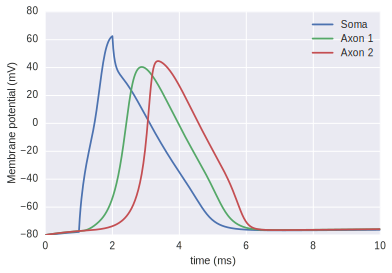

In [11]:
pp.plot(t_, np.c_[v_s, v_a1, v_a2])
pp.xlabel('time (ms)')
pp.ylabel('Membrane potential (mV)')
pp.legend(('Soma', 'Axon 1', 'Axon 2'))

For validation, here is the graphical output from NEURON:

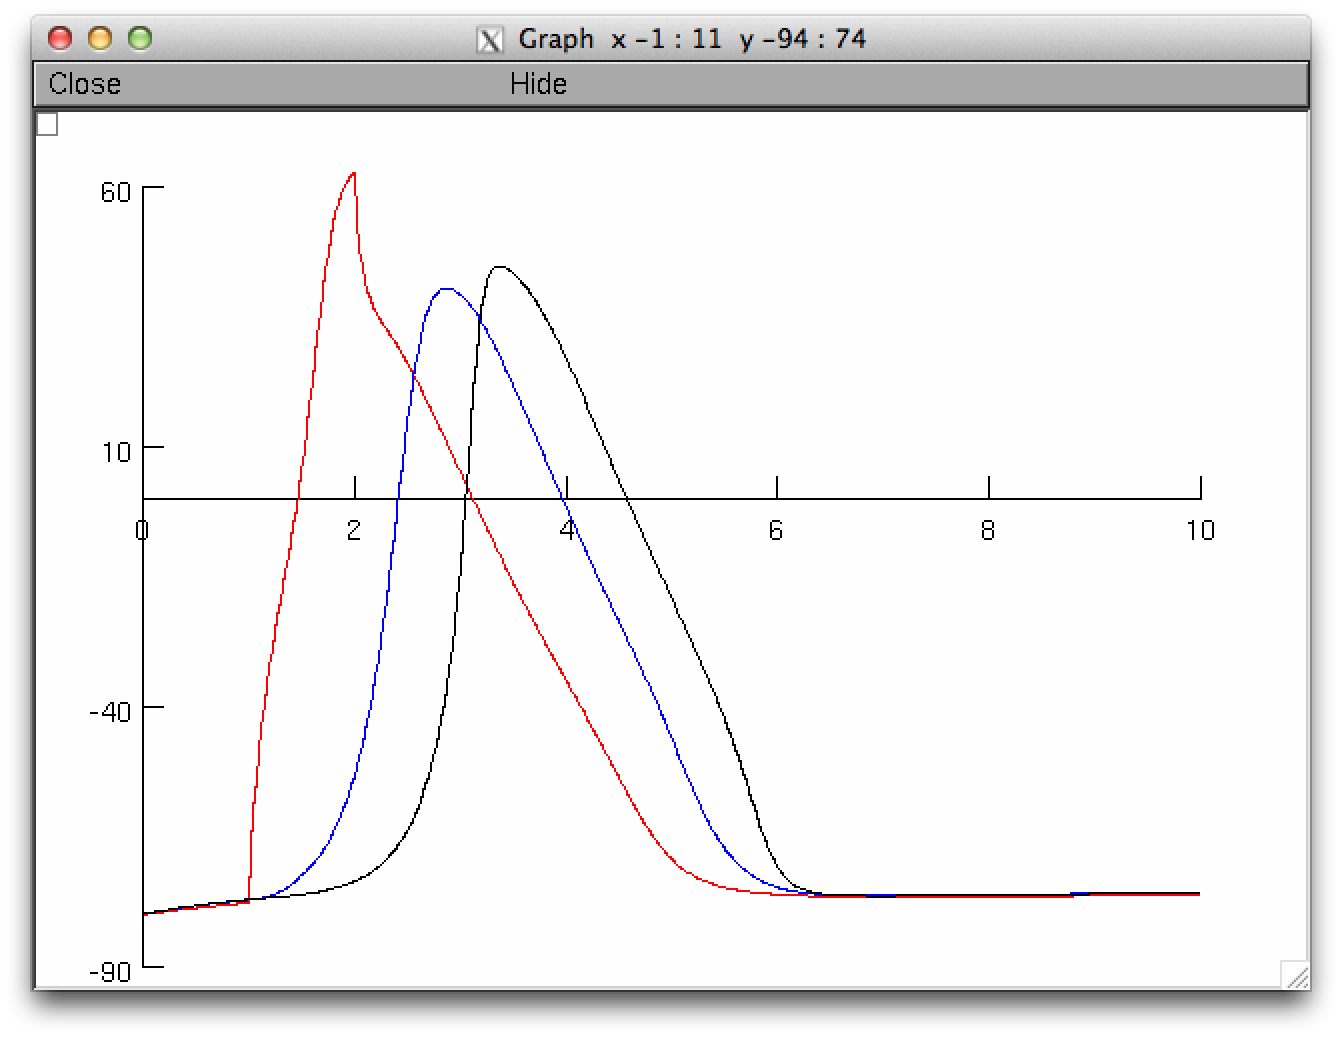

In [12]:
from IPython.display import Image
Image(filename='NEURON_plot.png', width=671, height=519)